In [3]:
import polars as pl
from pathlib import Path

DATA_PATH = Path.home() / "Documents/kaggle/hull_tactical/data"

train = pl.read_csv(DATA_PATH / "train.csv")
test  = pl.read_csv(DATA_PATH / "test.csv")

print(train.shape, test.shape)
print(train.columns[:20])
train.head(5)


(9021, 98) (10, 99)
['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18']


date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
0,0,0,0,1,1,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.002421,0.000301,-0.003038
1,0,0,0,1,1,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.008495,0.000303,-0.009114
2,0,0,0,1,0,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.009624,0.000301,-0.010243
3,0,0,0,1,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.004662,0.000299,0.004046
4,0,0,0,1,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.011686,0.000299,-0.012301


In [4]:
# Cast all non-date columns to float where possible
train = train.with_columns(
    pl.all().exclude("date_id").cast(pl.Float64, strict=False)
)

# confirm types
train.dtypes[:10]

[Int64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64]

In [5]:
train.head(3)

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.002421,0.000301,-0.003038
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.008495,0.000303,-0.009114
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.009624,0.000301,-0.010243


In [6]:
import polars as pl

null_counts = (
    train
    .select(pl.all().null_count())                                 # one-row DF of counts
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
    .sort("nulls", descending=True)
)

null_counts.head(20)

column,nulls
str,u32
"""E7""",6969
"""V10""",6049
"""S3""",5733
"""M1""",5547
"""M13""",5540
…,…
"""E20""",1616
"""P7""",1616
"""P5""",1574


In [7]:
import polars as pl

N = train.height
THRESH = int(0.5 * N)  # drop columns with >50% nulls

# 1) null counts as Series
nc = (
    train
    .select(pl.all().null_count())
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
)

# 2) keep/drop lists
to_keep = nc.filter(pl.col("nulls") <= THRESH)["column"].to_list()
to_drop = nc.filter(pl.col("nulls") > THRESH)["column"].to_list()

# 3) always keep these even if nully (index/targets)
ALWAYS_KEEP = {"date_id", "market_forward_excess_returns"}
to_keep = list(sorted(set(to_keep).union(ALWAYS_KEEP)))
to_drop = [c for c in to_drop if c not in ALWAYS_KEEP]

print(f"keep: {len(to_keep)} cols | drop: {len(to_drop)} cols")
# peek which got dropped
to_drop[:15]

keep: 90 cols | drop: 8 cols


['E7', 'M1', 'M13', 'M14', 'M6', 'S3', 'V10', 'V9']

In [8]:
train_filled = train.select([
    pl.when(pl.col(c).is_null())
    .then(pl.col(c).mean())
    .otherwise(pl.col(c))
    .cast(pl.Float64)
    .alias(c)
    for c in to_keep
])

In [9]:
train_filled.dtypes[:10]
train_filled.null_count().sum()
train_filled.head(3)

D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,…,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S4,S5,S6,S7,S8,S9,V1,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,date_id,forward_returns,market_forward_excess_returns,risk_free_rate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.564376,0.503676,0.125415,0.118313,0.012279,0.006991,0.486758,-0.047978,-0.009339,0.098024,0.116761,0.504014,0.90539,0.346242,0.016857,0.598541,0.122023,-0.272228,0.26591,0.74532,-0.522922,0.607538,0.551064,0.186341,0.456389,0.706785,0.572773,0.187819,…,1.260329,-0.020481,0.508742,-0.36495,0.495414,0.500406,0.001178,0.052918,0.249174,1.543061,0.393674,0.241018,0.437959,0.432863,0.265411,0.025082,0.456036,0.034151,0.515287,0.494731,0.079207,0.456539,0.325772,0.230551,0.253973,0.111299,0.50896,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,0.0,-0.002421,-0.003038,0.000301
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.564376,0.503676,0.125415,0.118313,0.012279,0.006991,0.486758,-0.047978,-0.009339,0.098024,0.116761,0.504014,0.90539,0.346242,0.016857,0.598541,0.122023,-0.272228,0.26591,0.74532,-0.522922,0.607538,0.551064,0.186341,0.456389,0.706785,0.572773,0.187819,…,1.260329,-0.020481,0.508742,-0.36495,0.495414,0.500406,0.001178,0.052918,0.249174,1.543061,0.393674,0.241018,0.437959,0.432863,0.265411,0.025082,0.456036,0.034151,0.515287,0.494731,0.079207,0.456539,0.325772,0.230551,0.253973,0.111299,0.50896,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,1.0,-0.008495,-0.009114,0.000303
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.564376,0.503676,0.125415,0.118313,0.012279,0.006991,0.486758,-0.047978,-0.009339,0.098024,0.116761,0.504014,0.90539,0.346242,0.016857,0.598541,0.122023,-0.272228,0.26591,0.74532,-0.522922,0.607538,0.551064,0.186341,0.456389,0.706785,0.572773,0.187819,…,1.260329,-0.020481,0.508742,-0.36495,0.495414,0.500406,0.001178,0.052918,0.249174,1.543061,0.393674,0.241018,0.437959,0.432863,0.265411,0.025082,0.456036,0.034151,0.515287,0.494731,0.079207,0.456539,0.325772,0.230551,0.253973,0.111299,0.50896,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,2.0,-0.009624,-0.010243,0.000301


In [10]:
train.select([
    pl.col("market_forward_excess_returns").mean().alias("mean"),
    pl.col("market_forward_excess_returns").std().alias("std"),
    pl.col("market_forward_excess_returns").min().alias("min"),
    pl.col("market_forward_excess_returns").max().alias("max"),
])

mean,std,min,max
f64,f64,f64,f64
0.000053,0.010558,-0.040582,0.040551


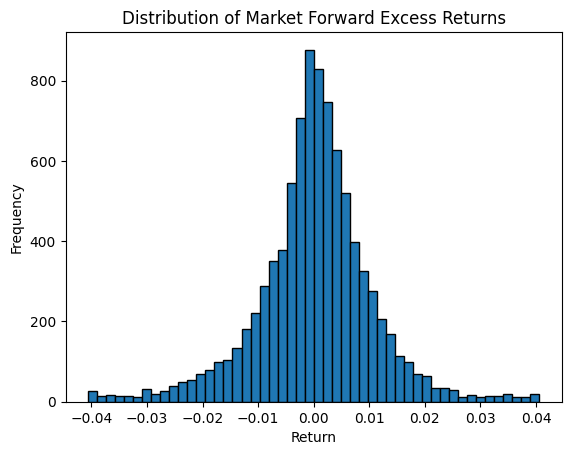

In [11]:
import matplotlib.pyplot as plt

plt.hist(
    train_filled["market_forward_excess_returns"].to_numpy(),
    bins=50,
    edgecolor="black"
)
plt.title("Distribution of Market Forward Excess Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

In [12]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

y = train["market_forward_excess_returns"].to_numpy()
X = train.drop(["market_forward_excess_returns"]).to_pandas()

# Fill any remaining NaNs
X = X.fillna(X.mean())

tscv = TimeSeriesSplit(n_splits=5)

for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}: train={train_idx[0]}–{train_idx[-1]}, val={val_idx[0]}–{val_idx[-1]}")

Fold 1: train=0–1505, val=1506–3008
Fold 2: train=0–3008, val=3009–4511
Fold 3: train=0–4511, val=4512–6014
Fold 4: train=0–6014, val=6015–7517
Fold 5: train=0–7517, val=7518–9020


In [13]:
def sharpe_like(y_true, y_pred):
    r = y_pred - y_true
    return np.mean(r) / (np.std(r) + 1e-9)

mean_pred = np.full_like(y, y.mean())

scores = []
for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    y_val = y[val_idx]
    y_pred = mean_pred[val_idx]
    score = sharpe_like(y_val, y_pred)
    scores.append(score)
    print(f"Fold {i+1} Sharpe-like: {score:.6f}")

print("Average Sharpe-like CV:", np.mean(scores))

Fold 1 Sharpe-like: -0.000347
Fold 2 Sharpe-like: 0.024497
Fold 3 Sharpe-like: -0.000565
Fold 4 Sharpe-like: -0.009725
Fold 5 Sharpe-like: -0.018547
Average Sharpe-like CV: -0.0009372756983632959


In [14]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=100000)

scores = []
for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    enet.fit(X_train, y_train)
    y_pred = enet.predict(X_val)
    score = sharpe_like(y_val, y_pred)
    scores.append(score)
    print(f"Fold {i+1} Sharpe-like: {score:.6f}")

print("Average Sharpe-like CV:", np.mean(scores))

Fold 1 Sharpe-like: 0.065606
Fold 2 Sharpe-like: -0.029033
Fold 3 Sharpe-like: -0.019255
Fold 4 Sharpe-like: -0.015440
Fold 5 Sharpe-like: -0.004284
Average Sharpe-like CV: -0.0004813410397651619
